### Library Import

In [12]:
import os
import pandas as pd
import numpy as np
import pickle

import PIL
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline 

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorboard.plugins.hparams import api as hp

import altair as alt
import seaborn as sns

import importlib

import warnings
warnings.filterwarnings('ignore')


In [13]:
# load in test_train_split custom function
from sklearn.metrics import confusion_matrix
import train
importlib.reload(train)
from train import test_train_split, train_test_model, run
import charts
importlib.reload(charts)
from charts import line_chart, plot_confusion_matrix_2

# Loading in Images

#### From pickeled files
For loading the images for the model simply run the the below code

In [14]:
# to load image files from pickles both train and test
dir = os.getcwd()

with open('{}/artifacts/{}'.format(dir, 'train_images_pkl.pkl'), 'rb') as pickle_file: #train_images_pkl_all.pkl
    train_data = pickle.load(pickle_file)

with open('{}/artifacts/{}'.format(dir, 'test_images_pkl.pkl'), 'rb') as pickle_file: #test_images_pkl_even_ratio.pkl
    test_data = pickle.load(pickle_file)


In [15]:
#resize test data
import random 
random.seed(42)
random.shuffle(test_data)
test_data_images, test_data_labels = zip(*test_data)
images_test, labels_test = zip(*test_data)

images_final_test = []
for img in images_test:
    img = Image.fromarray(img)
    # img = img.resize((186, 100))
    img = img.resize((177, 100))
    images_final_test.append(np.array(img))
    # print(img.shape)
# input_shape = images_final_test.shape[1:]
# print(input_shape)

test_data_images = [np.array(Image.fromarray(img).convert('RGB')) for img in images_final_test]
test_data_images = np.array(test_data_images)/255

Now that we have loaded the images we can split the training set in to training, development and test images. We have imported a function that we have created for this. 

In [22]:
#splitting in to test train split for the training data
train_images, train_labels, dev_images, dev_labels, test_images, test_labels = test_train_split(train_data)
print(np.array(train_images).shape)

#normalize the images
train_images, dev_images, test_images = np.array(train_images) / 255.0, \
                                        np.array(dev_images) / 255.0, \
                                        np.array(test_images) / 255.0

print(train_images.shape)

train_images = tf.convert_to_tensor(train_images, dtype=tf.float32)
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.float32)
test_images = tf.convert_to_tensor(test_images, dtype=tf.float32)
test_labels = tf.convert_to_tensor(test_labels, dtype=tf.float32)

input_shape = train_images.shape[1:]
print(input_shape)
print(train_images.shape)
print(train_labels.shape)

(1516, 100, 177, 3)
(1516, 100, 177, 3)
(100, 177, 3)
(1516, 100, 177, 3)
(1516, 1)


In [25]:
test_data_images, test_data_labels, dev_data_images, dev_data_labels, last_data_images, last_data_labels = test_train_split(test_data)
test_data_images = [np.array(Image.fromarray(img).convert('RGB')) for img in test_data_images]
dev_data_images = [np.array(Image.fromarray(img).convert('RGB')) for img in dev_data_images]
last_data_images = [np.array(Image.fromarray(img).convert('RGB')) for img in last_data_images]
print(np.array(test_data_images).shape)

test_data_images, dev_data_images, last_data_images = np.array(test_data_images) / 255.0, \
                                        np.array(dev_data_images) / 255.0, \
                                        np.array(last_data_images) / 255.0

print(test_data_images.shape)                                       

test_data_images = tf.convert_to_tensor(test_data_images, dtype=tf.float32)
test_data_labels = tf.convert_to_tensor(test_data_labels, dtype=tf.float32)
dev_data_images = tf.convert_to_tensor(dev_data_images, dtype=tf.float32)
dev_data_labels = tf.convert_to_tensor(dev_data_labels, dtype=tf.float32)
last_data_images = tf.convert_to_tensor(last_data_images, dtype=tf.float32)
last_data_labels = tf.convert_to_tensor(last_data_labels, dtype=tf.float32)

print(test_data_images.shape)
print(test_data_labels.shape)

(3491, 100, 177, 3)
(3491, 100, 177, 3)
(3491, 100, 177, 3)
(3491, 1)


# Hyperparameter Tuning

In [7]:
from tensorboard.plugins.hparams import api as hp
# %load_ext tensorboard
%reload_ext tensorboard
#! rm -rf ./logs/

In [26]:
session_num = 0
epochs = 50
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([64]))#, 64])) #8, 16
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
dropout_rate = 0.1
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['RMSprop']))#,'adam', 'Nadam'])) #'sgd','Adagrad'

params = []
losses = []
accuracies = []
f1_scores = []
precisions = []
recalls = []
aucs = []
cms = []
units = []
dropouts = []
optimizers = []
histories = []
modelz = []
predictions = []


# epochs = 50
#{'num_units': 64, 'dropout': 0.1, 'optimizer': 'adam'} 88/91
#{'num_units': 64, 'dropout': 0.1, 'optimizer': 'RMSprop'} 88/93
#{'num_units': 64, 'dropout': 0.1, 'optimizer': 'Nadam'} 89/92
#{'num_units': 32, 'dropout': 0.1, 'optimizer': 'Nadam'} 89/92
#{'num_units': 16, 'dropout': 0.2, 'optimizer': 'RMSprop'} 84/91

for num_units in HP_NUM_UNITS.domain.values:
    #for dropout_rate in HP_DROPOUT.domain.min_value:#, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
        hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
        }
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        units.append(num_units)
        dropouts.append(dropout_rate)
        optimizers.append(optimizer)
        model = run('logs/hparam_tuning/' + run_name, hparams, epochs, input_shape,train_images,train_labels,test_images, test_labels,
                HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER, predictions,
                params, losses, accuracies, f1_scores, precisions, recalls, cms, aucs,
                units, dropouts, optimizers, histories, augmentModel=True)
        modelz.append(model)
        session_num += 1

--- Starting trial: run-0
{'num_units': 64, 'dropout': 0.1, 'optimizer': 'RMSprop'}
Epoch 1/25
48/48 [==============================] - 13s 246ms/step - loss: 0.7911 - accuracy: 0.5877 - f1_m: 0.6793 - precision_m: 0.5530 - recall_m: 0.9063
Epoch 2/25
48/48 [==============================] - 12s 245ms/step - loss: 0.5520 - accuracy: 0.7190 - f1_m: 0.7235 - precision_m: 0.5753 - recall_m: 0.9902
Epoch 3/25
48/48 [==============================] - 11s 238ms/step - loss: 0.4235 - accuracy: 0.8015 - f1_m: 0.7249 - precision_m: 0.5766 - recall_m: 0.9960
Epoch 4/25
48/48 [==============================] - 11s 228ms/step - loss: 0.3087 - accuracy: 0.8602 - f1_m: 0.7218 - precision_m: 0.5722 - recall_m: 0.9985
Epoch 5/25
48/48 [==============================] - 11s 224ms/step - loss: 0.2706 - accuracy: 0.8931 - f1_m: 0.7279 - precision_m: 0.5762 - recall_m: 1.0000
Epoch 6/25
48/48 [==============================] - 11s 221ms/step - loss: 0.2004 - accuracy: 0.9182 - f1_m: 0.7256 - precision_m: 

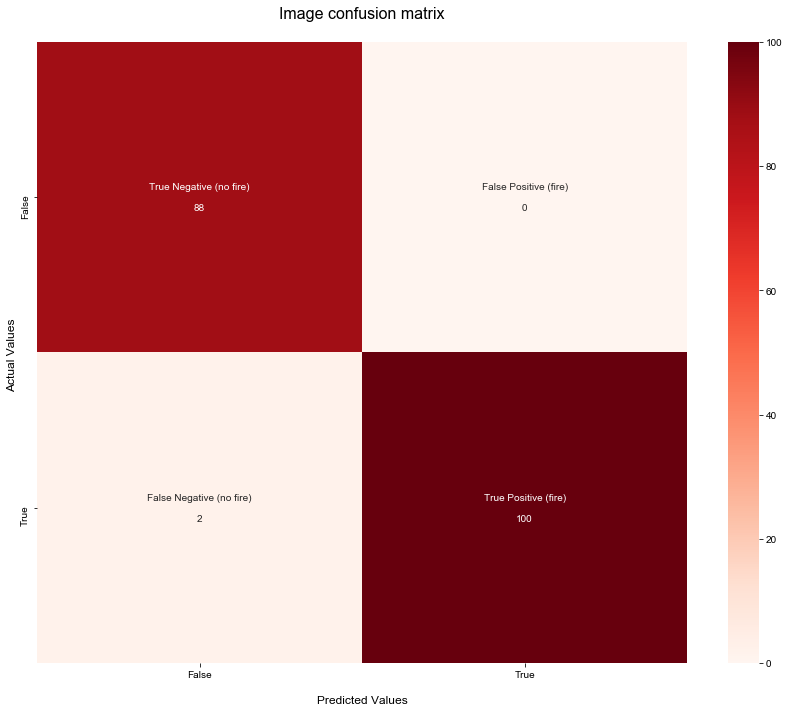

In [27]:
#dataframe assembly for model comparison
#integrate confusion matrices as well

modelDf = pd.DataFrame(list(zip(units, dropouts, optimizers, losses, accuracies, f1_scores, precisions, recalls, cms)),#aucs, 
               columns =['units', 'dropouts', 'optimizers', 'losses', 'accuracies', 'f1_scores', 'precisions', 'recalls', 'cms'])#'aucs',

modelDf['cms'].values[0]

plot_confusion_matrix_2(modelDf['cms'].values[0],normalize=False)

In [28]:
# prediction = model.predict(x=test_images, steps=len(test_images), verbose=0)
# cm = confusion_matrix(y_true=test_labels, y_pred=np.argmax(prediction, axis=-1))
# print(np.argmax(prediction, axis=-1).shape)
# print(test_labels.shape)

predictions2 = model.predict(x=test_data_images, steps=len(test_data_images), verbose=0)
cm2 = confusion_matrix(y_true=test_data_labels, y_pred=np.argmax(predictions2, axis=-1))
print(np.argmax(predictions2, axis=-1).shape)
print(test_data_labels.shape)

(3491,)
(3491, 1)


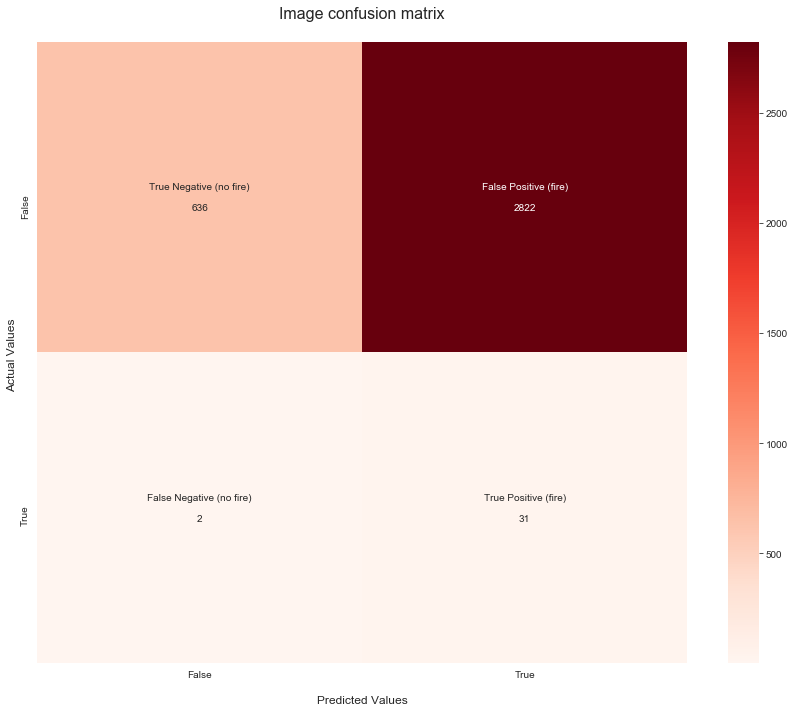

In [29]:

# modelDf['test_cms'].values[0]
# plot_confusion_matrix_2(modelDf['test_cms'].values[0],normalize=False)

plot_confusion_matrix_2(cm2,normalize=False)

In [ ]:

history_df = pd.DataFrame(histories[0].history).reset_index()
history_df

,index,loss,accuracy,f1_m,precision_m,recall_m
0,0,0.70714,0.550792,0.7145,0.568331,0.982416


In [ ]:
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

# for i in range(len(list(modelDf.optimizers))):
#     cls = modelDf.iloc[i,2]
#     plot_confusion_matrix_2(modelDf[modelDf['optimizers']==cls]['cms'][i])
#     ax.title.set_text(type(cls).__name__)
# plt.tight_layout()  
# plt.show()